In [0]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import random
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from operator import itemgetter
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [0]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda:0'

In [0]:
train = pd.read_csv("/content/drive/My Drive/ML/FDA/HW3/data/SPX500/train.csv")
test = pd.read_csv("/content/drive/My Drive/ML/FDA/HW3/data/SPX500/test.csv")

In [4]:
train.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


# Setting date as index

In [0]:
data_cleaner = [train, test]
data_0 = test.copy(deep=True)

In [6]:
data_0.tail()

,Date,Open Price,Close Price,High Price,Low Price,Volume
247,24-Dec-2018,2400.56,2351.10,2410.34,2351.10,1662758784
248,26-Dec-2018,2363.12,2467.70,2467.76,2346.58,2611875072
249,27-Dec-2018,2442.50,2488.83,2489.10,2397.94,2386466304
250,28-Dec-2018,2498.77,2485.74,2520.27,2472.89,2080726656
251,31-Dec-2018,2498.94,2506.85,2509.24,2482.82,1912680064


In [0]:
for data in data_cleaner:
  data['Day'] = pd.to_datetime(data['Date'],infer_datetime_format = True)
  data = data.set_index(['Day'])

In [0]:
train = train.set_index(['Day'])
test = test.set_index(['Day'])

In [0]:
# export Open_price.csv
export = train['Open Price']
export.head()
export.to_csv('open_price.csv')

In [10]:
export.head()

Day
2009-01-02    902.99
2009-01-05    929.17
2009-01-06    931.17
2009-01-07    927.45
2009-01-08    905.73
Name: Open Price, dtype: float64

# Visualization

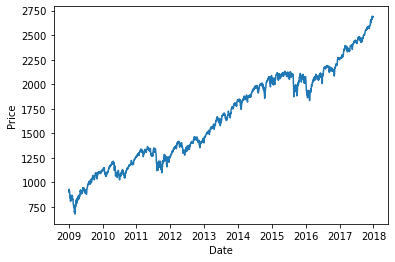

In [11]:
plt.plot(train.index,train['Open Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

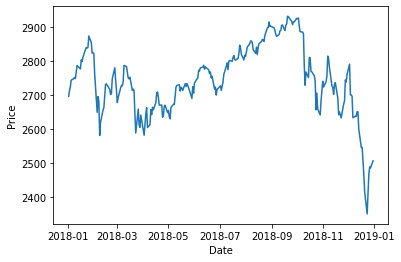

In [12]:
plt.plot(test.index,test['Close Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

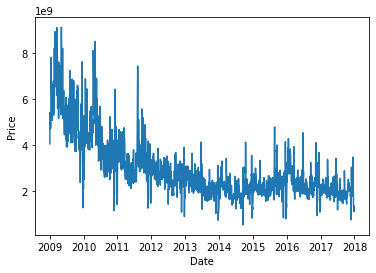

In [13]:
plt.plot(train.index,train['Volume'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

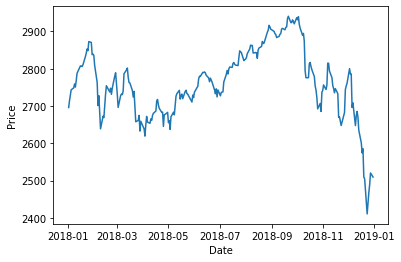

In [14]:
plt.plot(test.index,test['High Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

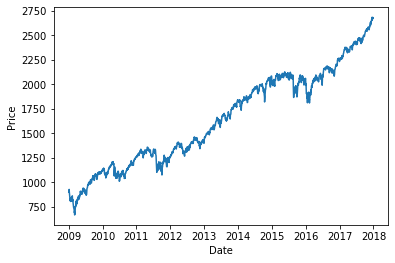

In [15]:
plt.plot(train.index,train['Low Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

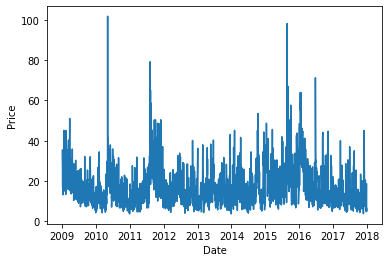

In [16]:
train['High-Low']=train['High Price']-train['Low Price']
plt.plot(train.index,train['High-Low'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

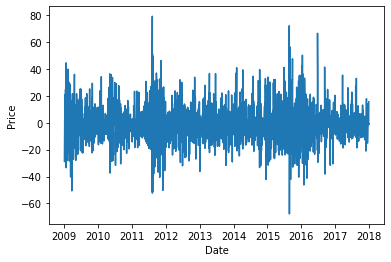

In [17]:
train['Open-Close']=train['Open Price']-train['Close Price']
plt.plot(train.index,train['Open-Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Data Processing
- Adding Day of the week
  - Stock prices may have a larger deviation on Mondays and Fridays so adding day of the week may help forecasting

In [0]:
def to_week_day(date):
  return datetime.strptime(date, "%d-%b-%Y").weekday()
train['WeekDay'] = train['Date'].apply(to_week_day)

In [19]:
test.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
Day,,,,,,
2018-01-02,02-Jan-2018,2683.73,2695.81,2695.89,2682.36,1846463232
2018-01-03,03-Jan-2018,2697.85,2713.06,2714.37,2697.77,2090595328
2018-01-04,04-Jan-2018,2719.31,2723.99,2729.29,2719.07,2100767744
2018-01-05,05-Jan-2018,2731.33,2743.15,2743.45,2727.92,1918869120
2018-01-08,08-Jan-2018,2742.67,2747.71,2748.51,2737.60,1894823936


In [0]:
for data in data_cleaner:
  data['WeekDay'] = data['Date'].apply(to_week_day)

Day
2009-01-02    902.99
2009-01-05    929.17
2009-01-06    931.17
2009-01-07    927.45
2009-01-08    905.73
Name: Open Price, dtype: float64

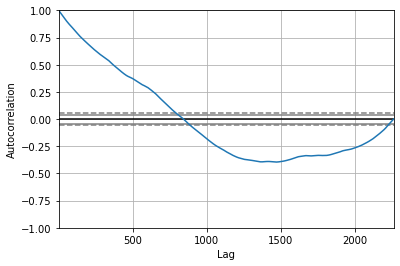

In [21]:



series = read_csv("/content/open_price.csv", header=0, parse_dates=[0], index_col=0, squeeze=True)
# series = read_csv("/content/open_price.csv")
autocorrelation_plot(series)
# plt.show()
series.head()

# 1 Facebook Prophet

## 1.1 Data Preprocessing

In [22]:
df = pd.read_csv('/content/drive/My Drive/ML/FDA/HW3/data/SPX500/train.csv')
test = pd.read_csv('/content/drive/My Drive/ML/FDA/HW3/data/SPX500/test.csv')
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


In [23]:


df['ds'] = pd.to_datetime(df['Date'],infer_datetime_format = True)
test['ds'] = pd.to_datetime(test['Date'],infer_datetime_format = True)
test['y'] = (test['Open Price'])
df['y'] = (df['Open Price'])
df.head()


,Date,Open Price,Close Price,High Price,Low Price,Volume,ds,y
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,2009-01-02,902.99
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,2009-01-05,929.17
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,2009-01-06,931.17
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,2009-01-07,927.45
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,2009-01-08,905.73


## 1.2 Model Building + Forecasting

In [24]:
m = Prophet(growth='linear')
m.fit(df)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future = m.make_future_dataframe(periods=367, freq='D')
fcst = m.predict(future)
fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-01-02,825.260818,772.828607,877.077959,825.260818,825.260818,0.236833,0.236833,0.236833,-14.025168,-14.025168,-14.025168,14.262002,14.262002,14.262002,0.0,0.0,0.0,825.497651
1,2009-01-05,825.773739,774.314655,875.311500,825.773739,825.773739,-1.176469,-1.176469,-1.176469,-15.104750,-15.104750,-15.104750,13.928280,13.928280,13.928280,0.0,0.0,0.0,824.597270
2,2009-01-06,825.944713,776.262440,875.138015,825.944713,825.944713,-1.835030,-1.835030,-1.835030,-15.310428,-15.310428,-15.310428,13.475398,13.475398,13.475398,0.0,0.0,0.0,824.109683
3,2009-01-07,826.115687,772.839610,867.525970,826.115687,826.115687,-2.345495,-2.345495,-2.345495,-15.186068,-15.186068,-15.186068,12.840572,12.840572,12.840572,0.0,0.0,0.0,823.770192
4,2009-01-08,826.286661,774.198140,872.649223,826.286661,826.286661,-2.754397,-2.754397,-2.754397,-14.776963,-14.776963,-14.776963,12.022567,12.022567,12.022567,0.0,0.0,0.0,823.532264


In [0]:
pred = fcst[(fcst['ds'].isin(test['ds']))]

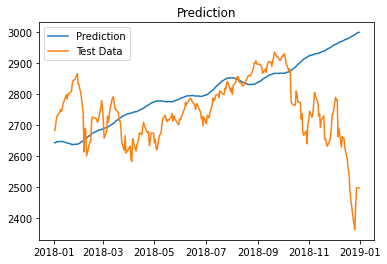

In [27]:
plt.plot(pred['ds'],pred['yhat'],label = 'Prediction')
plt.plot(test['ds'],test['y'],label = 'Test Data')
plt.legend(loc = 'upper left')
plt.title('Prediction')
plt.show()

In [0]:
predictions = pred['yhat']
expected = test['y']

In [29]:
import math
mse = mean_squared_error(expected, predictions)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 155.725154


# 2 Long Short Term Memory (LSTM)


## 2.1 Preprocessing

In [30]:
train = pd.read_csv("/content/drive/My Drive/ML/FDA/HW3/data/SPX500/train.csv")
test = pd.read_csv("/content/drive/My Drive/ML/FDA/HW3/data/SPX500/test.csv")
train['ds'] = pd.to_datetime(train['Date'],infer_datetime_format = True)
test['ds'] = pd.to_datetime(test['Date'],infer_datetime_format = True)
train.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,ds
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,2009-01-02
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,2009-01-05
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,2009-01-06
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,2009-01-07
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,2009-01-08


In [31]:
train = train[['ds','Open Price']]
test = test[['ds','Open Price']]
train = train.set_index(['ds'])
test = test.set_index(['ds'])
train.head()

,Open Price
ds,
2009-01-02,902.99
2009-01-05,929.17
2009-01-06,931.17
2009-01-07,927.45
2009-01-08,905.73


In [32]:
scaler  = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train['Open Price'].values.reshape(-1,1))
train['Open Price'] = scaler.transform(train['Open Price'].values.reshape(-1,1))
test['Open Price'] = scaler.transform(test['Open Price'].values.reshape(-1,1))
print(train['Open Price'])

ds
2009-01-02   -0.777782
2009-01-05   -0.751777
2009-01-06   -0.749790
2009-01-07   -0.753485
2009-01-08   -0.775060
                ...   
2017-12-22    0.991567
2017-12-26    0.986471
2017-12-27    0.989461
2017-12-28    0.993434
2017-12-29    0.996464
Name: Open Price, Length: 2264, dtype: float64


In [33]:
def load_data(data, look_back):
    data_raw = data.values
    data = []
    # create lookback data 
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    data = np.array(data);
    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]

    return [x_train, y_train]
look_back = 20 # number of data to look back 
x_train, y_train = load_data(train, look_back)
x_test, y_test = load_data(test,look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2244, 19, 1)
y_train.shape =  (2244, 1)
x_test.shape =  (232, 19, 1)
y_test.shape =  (232, 1)


In [0]:
# to Tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [35]:
y_train.size(),x_train.size()

(torch.Size([2244, 1]), torch.Size([2244, 19, 1]))

In [0]:
n_steps = look_back-1
batch_size = y_train.shape[0]
num_epochs = 100 


train_ld = torch.utils.data.TensorDataset(x_train,y_train)
test_ld = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_ld, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_ld, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 2.2 Model Building 

In [0]:
input_dim = 1
hidden_dim = 32
num_layers = 1 
output_dim = 1

In [38]:
class LSTM(nn.Module):
  def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
    super(LSTM,self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :]) 
    return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
6
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning:

size_average and reduce args will be deprecated, please use reduction='mean' instead.



In [39]:
# Training
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    optimiser.zero_grad()
    # Forward
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    # Backward pass
    loss.backward()
    optimiser.step()

Epoch  10 MSE:  0.008954399265348911
Epoch  20 MSE:  0.006939257495105267
Epoch  30 MSE:  0.004614546429365873
Epoch  40 MSE:  0.0012521313037723303
Epoch  50 MSE:  0.00107011036016047
Epoch  60 MSE:  0.0006217765621840954
Epoch  70 MSE:  0.0005042355041950941
Epoch  80 MSE:  0.0004067571135237813
Epoch  90 MSE:  0.0003921372990589589


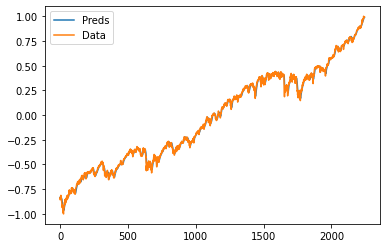

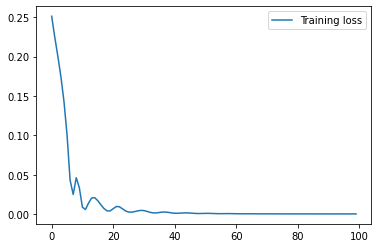

In [40]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

## 2.3 Forecasting

In [41]:
# make predictions
y_test_pred = model(x_test)

# invert_transform predictions

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test)

# calculate RMSE
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 48.77 RMSE


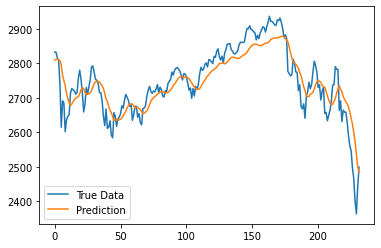

In [42]:
plt.plot(y_test,label = 'True Data')
plt.plot(y_test_pred,label = 'Prediction')
plt.legend(loc = 'lower left')
plt.show()

# 3 Stacked LSTM

In [0]:
train = pd.read_csv("/content/drive/My Drive/ML/FDA/HW3/data/SPX500/train.csv")
test = pd.read_csv("/content/drive/My Drive/ML/FDA/HW3/data/SPX500/test.csv")
train['ds'] = pd.to_datetime(train['Date'],infer_datetime_format = True)
test['ds'] = pd.to_datetime(test['Date'],infer_datetime_format = True)

In [44]:
train = train[['ds','Open Price']]
test = test[['ds','Open Price']]
train = train.set_index(['ds'])
test = test.set_index(['ds'])
train.head()

,Open Price
ds,
2009-01-02,902.99
2009-01-05,929.17
2009-01-06,931.17
2009-01-07,927.45
2009-01-08,905.73


In [45]:
scaler  = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train['Open Price'].values.reshape(-1,1))
train['Open Price'] = scaler.transform(train['Open Price'].values.reshape(-1,1))
test['Open Price'] = scaler.transform(test['Open Price'].values.reshape(-1,1))
print(train['Open Price'])

ds
2009-01-02   -0.777782
2009-01-05   -0.751777
2009-01-06   -0.749790
2009-01-07   -0.753485
2009-01-08   -0.775060
                ...   
2017-12-22    0.991567
2017-12-26    0.986471
2017-12-27    0.989461
2017-12-28    0.993434
2017-12-29    0.996464
Name: Open Price, Length: 2264, dtype: float64


## 3.1 Data Loading 

In [46]:
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
   
    # create look back sequence
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    data = np.array(data);
    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]

    return [x_train, y_train]
look_back = 50 # number of data to look back 
x_train, y_train = load_data(train, look_back)
x_test, y_test = load_data(test,look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2214, 49, 1)
y_train.shape =  (2214, 1)
x_test.shape =  (202, 49, 1)
y_test.shape =  (202, 1)


In [0]:
# to Tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [0]:
n_steps = look_back-1
batch_size = y_train.shape[0]
num_epochs = 100

train_ld = torch.utils.data.TensorDataset(x_train,y_train)
test_ld = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_ld, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_ld, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 3.2 Model Building

In [0]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

In [50]:
class LSTM_Stacked(nn.Module):
  def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
    super(LSTM_Stacked,self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers 
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :]) 
    return out
    
model = LSTM_Stacked(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM_Stacked(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning:

size_average and reduce args will be deprecated, please use reduction='mean' instead.



In [51]:
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Forward
    optimiser.zero_grad()
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    #backward
    loss.backward()
    optimiser.step()

Epoch  10 MSE:  0.00709572434425354
Epoch  20 MSE:  0.004758019465953112
Epoch  30 MSE:  0.0030955947004258633
Epoch  40 MSE:  0.0014243548503145576
Epoch  50 MSE:  0.0007610194152221084
Epoch  60 MSE:  0.0005106871831230819
Epoch  70 MSE:  0.00046346912859007716
Epoch  80 MSE:  0.00044982973486185074
Epoch  90 MSE:  0.00043384337914176285


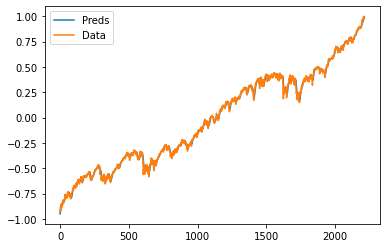

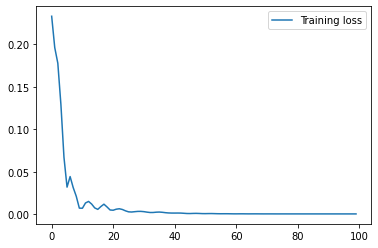

In [52]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

## 3.3 Forecasting

In [53]:
# make predictions
y_test_pred = model(x_test)

# inverse transform predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test)

# calculate RMSE
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 46.37 RMSE


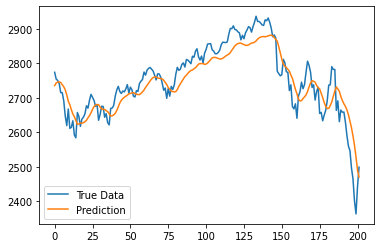

In [54]:
plt.plot(y_test,label = 'True Data')
plt.plot(y_test_pred,label = 'Prediction')
plt.legend(loc = 'lower left')
plt.show()